In [24]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Change the current working directory to the notebooks folder
os.chdir(r'C:\Users\A070050\OneDrive - Tata Steel Europe Ltd\Documents\notebooks')

data_file_path = r'..\dvl-data'  # Use relative path to dvl-data

In [3]:
file_name = '2024-04-04_DVL1_test_data_for_refit.csv'
full_path = os.path.join(data_file_path, file_name)

dvl1 = pd.read_csv(full_path, delimiter=',')
dvl1 = dvl1[dvl1['r_value'] != 0]

# full_path = '/Users/tonny/Desktop/tata_thesis_stage/dvl/2024-04-04_DVL1_test_data_for_refit.csv'
# dvl1 = pd.read_csv(full_path, delimiter=',')
# dvl1 = dvl1[dvl1['r_value'] != 0]
# dvl1

In [4]:
def map_steel_family(df):

    family_mapping = {
        # AHSS family
        '2F63': 'AHSS',
        '2F95': 'AHSS',
        '2Q91': 'AHSS',
        '3F63': 'AHSS',
        
        # CMn family
        '110E': 'CMn', '110F': 'CMn', '110H': 'CMn', '112H': 'CMn', 
        '112L': 'CMn', '114E': 'CMn', '116L': 'CMn', '125C': 'CMn',
        '126C': 'CMn', '126L': 'CMn', '180L': 'CMn', '180N': 'CMn',
        '184L': 'CMn', '184M': 'CMn', '186C': 'CMn', '187L': 'CMn',
        '180G': 'CMn', '111C': 'CMn', '114C': 'CMn', '114H': 'CMn',
        '121L': 'CMn', '1T46': 'CMn', '1T36': 'CMn', '1T86': 'CMn',
        '1S38': 'CMn', '1S42': 'CMn', '1T32': 'CMn', '1T80': 'CMn',
        '1T82': 'CMn', '1T34': 'CMn', '110B': 'CMn', '1P65': 'CMn',
        '184K': 'CMn', '1N47': 'CMn', '1N57': 'CMn', '123L': 'CMn',
        '115H': 'CMn', '1T44': 'CMn', '1T84': 'CMn', '1T94': 'CMn', 
        '115E': 'CMn', '1P85': 'CMn', 
        
        # HSLA family
        '1N80': 'HSLA', '1N31': 'HSLA', '1N60': 'HSLA', '1N61': 'HSLA',
        '1N81': 'HSLA', '1N91': 'HSLA', '1N84': 'HSLA', '1N64': 'HSLA',
        '1N94': 'HSLA', '1N32': 'HSLA', '1N33': 'HSLA', '1N62': 'HSLA',
        '1N63': 'HSLA', '1N82': 'HSLA', '1N83': 'HSLA', '1N92': 'HSLA',
        '1N93': 'HSLA', '1N36': 'HSLA', '1N37': 'HSLA', '1N66': 'HSLA',
        '1N67': 'HSLA', '1N86': 'HSLA', '1N87': 'HSLA', '1N96': 'HSLA',
        '1N97': 'HSLA', '1N38': 'HSLA', '1N39': 'HSLA', '1N68': 'HSLA',
        '1N69': 'HSLA', '1N88': 'HSLA', '1N98': 'HSLA', '1N99': 'HSLA',
        '3N73': 'HSLA', '3N73': 'HSLA',
        
        # IF family
        '514Z': 'IF', '515M': 'IF', '581G': 'IF', '590Q': 'IF',
        '590Z': 'IF', '591M': 'IF', '594Q': 'IF', '594Z': 'IF',
        '595M': 'IF', '542P': 'IF', '543P': 'IF', '544P': 'IF',
        '545P': 'IF', '540Z': 'IF', '541M': 'IF', '54AE': 'IF',
        '561P': 'IF', '592P': 'IF', '593P': 'IF', '598P': 'IF',
        '599P': 'IF', '59AD': 'IF', '552V': 'IF', '553V': 'IF',
        '589L': 'IF', '59TM': 'IF', '55AV': 'IF'
    }
    
    df_copy = df.copy()
    
    # Map steel family on the copy
    df_copy['steel_family'] = df_copy['steel_grade'].map(family_mapping)
    
    return df_copy

In [5]:
dvl1 = map_steel_family(dvl1)
dvl1['steel_family'].value_counts()

steel_family
IF      6094
HSLA    5712
CMn     3901
Name: count, dtype: int64

In [6]:
def remove_outliers(df):
    Q1 = df['r_value'].quantile(0.10)
    Q3 = df['r_value'].quantile(0.90)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df['r_value'] >= lower_bound) & (df['r_value'] <= upper_bound)]

In [7]:
# desc[(desc['model'] != 'n') are relevant features, these are handlabeled with my supervisor

path = '/Users/A070050/Tata Steel Europe Ltd/R&D NL Data Driven Steel - U3-2 r-value model/MDC_Data_Descriptions_MeCoMeP-r-value.xlsx'
# path = '/Users/tonny/Desktop/tata_thesis_stage/MDC_Data_Descriptions_MeCoMeP-r-value.xlsx'
desc = pd.read_excel(path, sheet_name=3)

tmp = desc[(desc['model'] != 'n') & (desc['Table Name'] == 'mecomep_dv21') 
             & ((desc['Input Type'] == 'Actual - Measurement or Count') | (desc['Input Type'] == 'Prediction - Calculation'))]
features_selected = tmp[['Attribute Name', 'Input Type']]

existing_columns = [col for col in features_selected['Attribute Name'] if col in dvl1.columns]
dvl1_selected = dvl1[existing_columns+['r_value', 'steel_grade']]

c:\Users\A070050\AppData\Local\Programs\Python\Python38\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [8]:
nan_cols = dvl1_selected.isna().sum().sort_values(ascending=False)
nan_cols = nan_cols[nan_cols > 0] #columns with no nan are not relevant
cols_to_drop = nan_cols[nan_cols > 100].index.tolist()
dvl1_selected = dvl1_selected.drop(cols_to_drop, axis=1)
dvl1_selected.dropna(inplace=True)

In [9]:
corr_threshold = 0.2

corr = dvl1_selected.drop(['steel_grade'], axis=1).corr()['r_value'].abs()
selected_features = corr[abs(corr) >= corr_threshold].index.tolist()

print(f'dropped {len(dvl1_selected.columns) - len(selected_features)} columns')

dropped 24 columns


In [10]:
# Dropping steelgrade occurences that dont appear often (less than 5)
dvl1_selected = dvl1_selected[selected_features+['steel_grade']]
counts = dvl1_selected['steel_grade'].value_counts()
filtered_values = counts[counts >= 5].index
dvl1_selected = dvl1_selected[dvl1_selected['steel_grade'].isin(filtered_values)]
dvl1_selected = map_steel_family(dvl1_selected).drop(['steel_grade'], axis=1)
dvl1_selected = dvl1_selected.groupby('steel_family').apply(remove_outliers).reset_index(drop=True)

dvl1_selected

,cold_roll_reduction,elong_tl_pct,elong_tm_pct,gauge_f1,gauge_f2,gauge_f3,gauge_f4,gauge_f5,gauge_f6,gauge_f7,...,tension_tm_exit_mpa,time_inter_f1,time_inter_f2,time_inter_f3,time_inter_f4,time_inter_f5,time_inter_f6,time_inter_f7,r_value,steel_family
0,66.97,2.0,16.0,24.529786,16.663215,11.979636,9.008755,6.573885,5.513293,4.56455,...,81.0,38.100,3.690,2.400,1.710,1.300,1.050,0.850,1.15,CMn
1,67.88,2.0,0.0,26.053005,18.053067,12.849053,9.586975,7.760840,6.249673,4.72489,...,118.0,39.484,4.328,2.860,2.009,1.481,1.179,0.862,1.05,CMn
2,67.90,2.0,16.0,24.351294,16.750388,12.294898,9.102001,6.660000,5.530000,4.70891,...,81.0,44.838,4.530,2.960,2.029,1.516,1.229,1.005,1.15,CMn
3,72.38,2.0,16.0,21.690000,12.760000,8.450000,5.960000,4.410000,3.450000,2.90239,...,90.0,72.496,3.640,2.051,1.351,0.940,0.684,0.542,1.05,CMn
4,72.38,2.0,16.0,20.780000,12.730000,8.530000,5.900000,4.410000,3.440000,2.89543,...,90.0,72.272,3.531,2.006,1.330,0.934,0.687,0.545,1.05,CMn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15591,78.13,1.0,15.0,26.590000,17.980000,12.760000,9.440000,7.160000,5.550000,3.80039,...,36.0,68.653,2.569,1.715,1.213,0.882,0.673,0.514,1.50,IF
15592,73.90,1.0,13.0,28.973028,20.959475,15.100574,11.654747,9.185976,7.139899,5.76871,...,47.0,34.770,2.870,2.030,1.470,1.120,0.870,0.700,1.65,IF
15593,80.32,1.0,15.0,26.670000,17.900000,12.060000,8.490000,6.530000,5.120000,4.37135,...,45.0,45.712,3.167,2.076,1.411,0.996,0.755,0.582,2.20,IF
15594,80.32,1.0,15.0,27.028830,18.710170,12.928046,9.371886,7.225700,5.603521,4.39936,...,49.0,35.765,3.247,2.170,1.481,1.049,0.790,0.610,2.15,IF


In [11]:
# labeling the features for each branch
features = [col for col in dvl1_selected.columns if col not in ['r_value', 'steel_family']]
features_dict = {
   'time': [col for col in features if 'time' in col.lower()], 
   'chemical': ['pct_al', 'pct_b', 'pct_c', 'pct_cr', 'pct_mn', 'pct_n', 'pct_nb', 'pct_si', 'pct_ti', 'pct_v', 'mfia_coil_frac_fer', 'mfia_et1_frac_fer', 'mfia_et2_frac_fer'],
}
features_dict['process'] = [col for col in features if col not in features_dict['time'] and col not in features_dict['chemical']]

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Split first to avoid data leakage
train_df, test_df = train_test_split(dvl1_selected, test_size=0.2, random_state=42)

# Scale the training set
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df.drop(['steel_family'], axis=1))
train_scaled_df = pd.DataFrame(train_scaled, columns=train_df.drop(['steel_family'], axis=1).columns)
train_scaled_df['steel_family'] = train_df['steel_family'].reset_index(drop=True)

# Scale the testing set using the scaler fitted on the training set
test_scaled = scaler.transform(test_df.drop(['steel_family'], axis=1))
test_scaled_df = pd.DataFrame(test_scaled, columns=test_df.drop(['steel_family'], axis=1).columns)
test_scaled_df['steel_family'] = test_df['steel_family'].reset_index(drop=True)

In [13]:
class MultiBranchSteelRegressor(nn.Module):
    def __init__(self, 
                 chemical_dim, time_dim, process_dim, 
                 base_hidden_units=64, branch_hidden_units=64, 
                 base_dropout_rate=0.2, branch_dropout_rate=0.2,
                 final_hidden_units=[128, 64], final_dropout_rate=0.2):
        super().__init__()
        
        # Track which branches are active
        self.has_chemical = chemical_dim > 0
        self.has_time = time_dim > 0
        self.has_process = process_dim > 0
        
        # Count active branches
        self.active_branches = sum([self.has_chemical, self.has_time, self.has_process])
        
        # Common base layer
        self.base_hidden_units = base_hidden_units
        self.common_base_layer = nn.Sequential(
            nn.Linear(chemical_dim + time_dim + process_dim, self.base_hidden_units),
            nn.BatchNorm1d(self.base_hidden_units),
            nn.ReLU(),
            nn.Dropout(base_dropout_rate)
        )
        
        # Branch hidden units and dropout rates
        self.branch_hidden_units = branch_hidden_units
        
        # Creating branch
        def create_branch(input_dim):
            return nn.Sequential(
                nn.Linear(input_dim, self.branch_hidden_units),
                nn.BatchNorm1d(self.branch_hidden_units),
                nn.ReLU(),
                nn.Dropout(branch_dropout_rate)
            )
        
        # Only create branches that have features
        if self.has_chemical:
            self.chemical_branch = create_branch(self.base_hidden_units)
        if self.has_time:
            self.time_branch = create_branch(self.base_hidden_units)
        if self.has_process:
            self.process_branch = create_branch(self.base_hidden_units)
        
        # Combined input dimension based on active branches only
        combined_dim = self.branch_hidden_units * self.active_branches
        
        # Final layers after concatenation
        final_layers = []
        input_dim = combined_dim
        for units in final_hidden_units:
            final_layers.append(nn.Linear(input_dim, units))
            final_layers.append(nn.BatchNorm1d(units))
            final_layers.append(nn.ReLU())
            final_layers.append(nn.Dropout(final_dropout_rate))
            input_dim = units
        final_layers.append(nn.Linear(input_dim, 1))  # Output layer
        
        self.final_layers = nn.Sequential(*final_layers)

    def forward(self, chemical, time, process):
        features = []
        
        # Concatenate all input features for the common base layer
        inputs = []
        if self.has_chemical:
            inputs.append(chemical)
        if self.has_time:
            inputs.append(time)
        if self.has_process:
            inputs.append(process)
        
        inputs = torch.cat(inputs, dim=1)  # Concatenate all inputs
        base_features = self.common_base_layer(inputs)  # Pass through the common base layer
        
        # Split base features into branches
        if self.has_chemical:
            features.append(self.chemical_branch(base_features))
        if self.has_time:
            features.append(self.time_branch(base_features))
        if self.has_process:
            features.append(self.process_branch(base_features))
        
        # Concatenate only active features
        combined = torch.cat(features, dim=1) if len(features) > 1 else features[0]
        return self.final_layers(combined)


In [14]:
def train_family_models(df, features_dict, num_epochs, hyperparameters):
    family_models = {}
    evaluation_results = {}
    batch_size = hyperparameters['batch_size']

    for family in df['steel_family'].unique():
        family_data = df[df['steel_family'] == family]

        # Initialize feature arrays and dimensions
        feature_arrays = {}
        feature_dims = {}

        # Process each feature category
        for category in ['chemical', 'time', 'process']:
            available_features = [col for col in features_dict[category] 
                                if col in family_data.columns]

            if available_features:
                # Scale each feature category independently
                scaler = StandardScaler()
                feature_arrays[category] = scaler.fit_transform(family_data[available_features].values)
                feature_dims[category] = len(available_features)
            else:
                feature_arrays[category] = np.zeros((len(family_data), 0))  # Empty array
                feature_dims[category] = 0

        # Prepare targets
        targets = family_data['r_value'].values

        # Split data
        split_data = train_test_split(
            feature_arrays['chemical'],
            feature_arrays['time'],
            feature_arrays['process'],
            targets,
            test_size=0.2,
            random_state=42
        )

        (X_train_chem, X_test_chem, X_train_time, X_test_time, 
         X_train_proc, X_test_proc, y_train, y_test) = split_data

        # Convert to tensors
        train_tensors = {
            'chemical': torch.FloatTensor(X_train_chem),
            'time': torch.FloatTensor(X_train_time),
            'process': torch.FloatTensor(X_train_proc)
        }

        test_tensors = {
            'chemical': torch.FloatTensor(X_test_chem),
            'time': torch.FloatTensor(X_test_time),
            'process': torch.FloatTensor(X_test_proc)
        }

        y_train_tensor = torch.FloatTensor(y_train)
        y_test_tensor = torch.FloatTensor(y_test)

        # Create DataLoader
        train_dataset = TensorDataset(
            train_tensors['chemical'],
            train_tensors['time'],
            train_tensors['process'],
            y_train_tensor
        )
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

        # Initialize model
        model = MultiBranchSteelRegressor(
            chemical_dim=feature_dims['chemical'],
            time_dim=feature_dims['time'],
            process_dim=feature_dims['process'],
            base_hidden_units=hyperparameters['base_hidden_units'],
            branch_hidden_units=hyperparameters['branch_hidden_units'],
            base_dropout_rate=hyperparameters['base_dropout_rate'],
            branch_dropout_rate=hyperparameters['branch_dropout_rate'],
            final_hidden_units=hyperparameters['final_hidden_units'],
            final_dropout_rate=hyperparameters['final_dropout_rate']
        )
        optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters['learning_rate'])
        criterion = nn.L1Loss()

        # Training loop
        model.train()
        for epoch in range(num_epochs):
            running_loss = 0.0
            for batch_chem, batch_time, batch_proc, batch_targets in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_chem, batch_time, batch_proc)
                loss = criterion(outputs, batch_targets.unsqueeze(1))
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

        # Evaluation
        model.eval()
        with torch.no_grad():
            y_pred = model(
                test_tensors['chemical'],
                test_tensors['time'],
                test_tensors['process']
            )
            test_loss = criterion(y_pred, y_test_tensor.unsqueeze(1)).item()
            y_pred_np = y_pred.numpy().flatten()
            r2 = r2_score(y_test, y_pred_np)

            evaluation_results[family] = {
                'test_loss': test_loss,
                'r2_score': r2
            }
            print(f"Evaluation for {family} - Test Loss: {test_loss:.4f}, R2: {r2:.4f}")

        family_models[family] = model

    return family_models, evaluation_results

In [15]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'learning_rate': [1e-3],
    'batch_size': [32, 64, 128],
    'base_hidden_units': [64, 128],
    'branch_hidden_units': [32, 64],
    'base_dropout_rate': [0, 0.2],
    'branch_dropout_rate': [0, 0.2],
    'final_hidden_units': [[128, 64], [256, 128]],
    'final_dropout_rate': [0, 0.2]
}
grid = ParameterGrid(param_grid)


In [16]:
# from tqdm import tqdm

# num_epochs = 50

# best_results = {}
# best_params = None

# for params in tqdm(grid, desc="Grid Search Progress", leave=True):
#     print(f"\nEvaluating hyperparameters: {params}")
    
#     family_models, evaluation_results = train_family_models(dvl1_scaled_df, features_dict, num_epochs, params)
    
#     avg_r2 = np.mean([evaluation_results[family]['r2_score'] for family in evaluation_results])
    
#     if best_params is None or avg_r2 > best_results['avg_r2']:
#         best_results = {
#             'avg_r2': avg_r2,
#             'evaluation_results': evaluation_results
#         }
#         best_params = params

#     print(f"Average R2 Score: {avg_r2:.4f}")

# print(f"\nBest Hyperparameters: {best_params}")
# print(f"Best R2 Score: {best_results['avg_r2']:.4f}")


In [17]:
best_params = {'base_dropout_rate': 0.2,
 'base_hidden_units': 128,
 'batch_size': 32,
 'branch_dropout_rate': 0.2,
 'branch_hidden_units': 64,
 'final_dropout_rate': 0.2,
 'final_hidden_units': [128, 64],
 'learning_rate': 0.001}

In [18]:
best_results = {'avg_r2': 0.5691215495488878,
 'evaluation_results': {'CMn': {'test_loss': 0.05790923163294792,
   'r2_score': 0.5423225559581195},
  'HSLA': {'test_loss': 0.02688261866569519, 'r2_score': 0.6970075400131952},
  'IF': {'test_loss': 0.12198413163423538, 'r2_score': 0.46803455267534877}}}

In [19]:
# best_results = {'avg_r2': 0.5774655195501973,
#  'evaluation_results': {'CMn': {'test_loss': 0.057762887328863144,
#    'r2_score': 0.543479086418242},
#   'HSLA': {'test_loss': 0.024983583018183708, 'r2_score': 0.718411446680632},
#   'IF': {'test_loss': 0.12141738831996918, 'r2_score': 0.47050602555171783}}}

In [20]:
family_models, eval = train_family_models(train_scaled_df, features_dict, 100, best_params)

Epoch [10/100], Loss: 0.1888
Epoch [20/100], Loss: 0.1750
Epoch [30/100], Loss: 0.1651
Epoch [40/100], Loss: 0.1686
Epoch [50/100], Loss: 0.1653
Epoch [60/100], Loss: 0.1550
Epoch [70/100], Loss: 0.1540
Epoch [80/100], Loss: 0.1486
Epoch [90/100], Loss: 0.1491
Epoch [100/100], Loss: 0.1424
Evaluation for CMn - Test Loss: 0.1638, R2: 0.5356
Epoch [10/100], Loss: 0.2641
Epoch [20/100], Loss: 0.2487
Epoch [30/100], Loss: 0.2422
Epoch [40/100], Loss: 0.2362
Epoch [50/100], Loss: 0.2337
Epoch [60/100], Loss: 0.2274
Epoch [70/100], Loss: 0.2204
Epoch [80/100], Loss: 0.2196
Epoch [90/100], Loss: 0.2145
Epoch [100/100], Loss: 0.2127
Evaluation for IF - Test Loss: 0.2540, R2: 0.4529
Epoch [10/100], Loss: 0.1555
Epoch [20/100], Loss: 0.1375
Epoch [30/100], Loss: 0.1276
Epoch [40/100], Loss: 0.1280
Epoch [50/100], Loss: 0.1221
Epoch [60/100], Loss: 0.1198
Epoch [70/100], Loss: 0.1185
Epoch [80/100], Loss: 0.1156
Epoch [90/100], Loss: 0.1132
Epoch [100/100], Loss: 0.1117
Evaluation for HSLA - Test

In [31]:
def plot_actual_vs_predicted(df, family_models, features_dict):
    families = df['steel_family'].unique()
    
    for family in families:
        # Filter data for the current family
        family_data = df[df['steel_family'] == family].drop(['steel_family'], axis=1)
        
        # Prepare feature arrays
        feature_arrays = {}
        for category in ['chemical', 'time', 'process']:
            available_features = [col for col in features_dict[category] 
                                  if col in family_data.columns]
            if available_features:
                scaler = StandardScaler()
                feature_arrays[category] = scaler.fit_transform(family_data[available_features].values)
            else:
                feature_arrays[category] = np.zeros((len(family_data), 0))
        
        # Convert features to tensors
        chemical_tensor = torch.FloatTensor(feature_arrays['chemical'])
        time_tensor = torch.FloatTensor(feature_arrays['time'])
        process_tensor = torch.FloatTensor(feature_arrays['process'])
        
        # Make predictions
        with torch.no_grad():
            predicted = family_models[family](
                chemical_tensor, 
                time_tensor, 
                process_tensor
            ).numpy().flatten()
        
        # Get actual values
        actual = family_data['r_value'].values
        
        # Calculate metrics
        r2 = r2_score(actual, predicted)
        mae = mean_absolute_error(actual, predicted)
        
        # Create a new figure for each family
        plt.figure(figsize=(10, 8))
        
        # Scatter plot
        plt.scatter(actual, predicted, alpha=0.5)
        
        # Linear regression line
        m, b = np.polyfit(actual, predicted, 1)
        plt.plot(actual, m*actual + b, color='red', linestyle='--', label='Regression Line')
        
        # Perfect prediction line
        plt.plot([actual.min(), actual.max()], 
                 [actual.min(), actual.max()], 
                 color='green', linestyle=':', label='Perfect Prediction')
        
        # Set plot limits with buffer
        buffer = 0.2
        x_min, x_max = actual.min() - (actual.max() - actual.min()) * buffer, actual.max() + (actual.max() - actual.min()) * buffer
        y_min, y_max = predicted.min() - (predicted.max() - predicted.min()) * buffer, predicted.max() + (predicted.max() - predicted.min()) * buffer
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        
        # Labeling
        plt.xlabel('Actual R-value')
        plt.ylabel('Predicted R-value')
        plt.title(f'{family} Family\nR² = {r2:.4f}, MAE = {mae:.4f}')
        plt.axis('equal')
        plt.legend()
        
        # Adjust layout and show plot
        plt.tight_layout()
        plt.show()

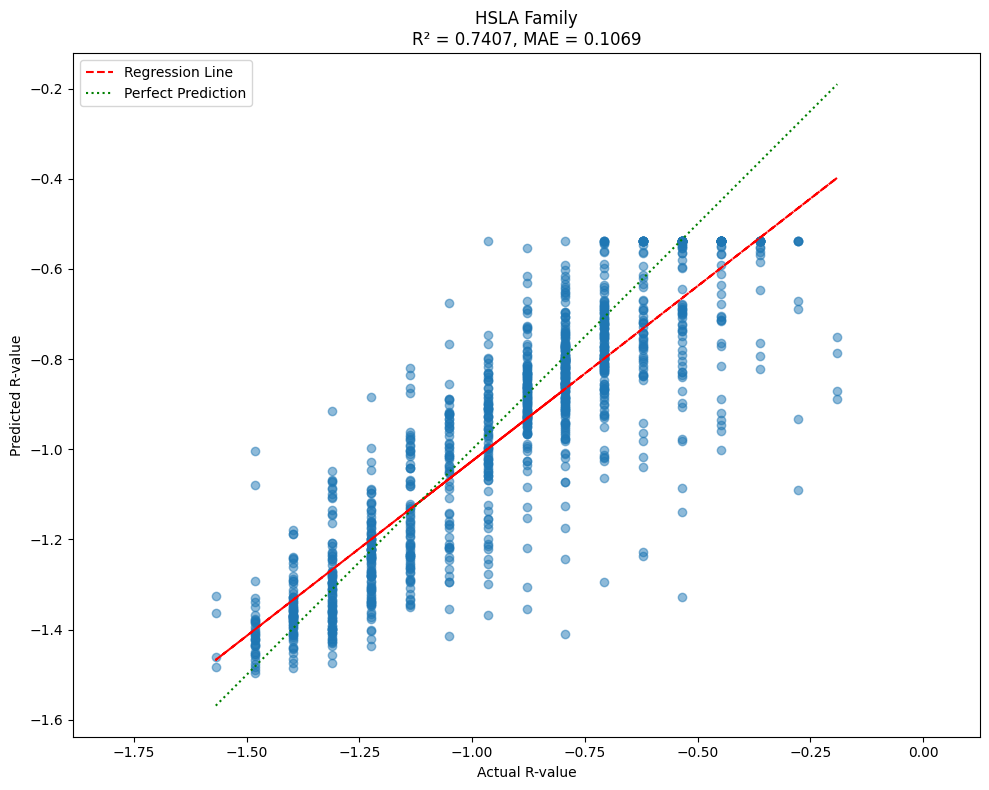

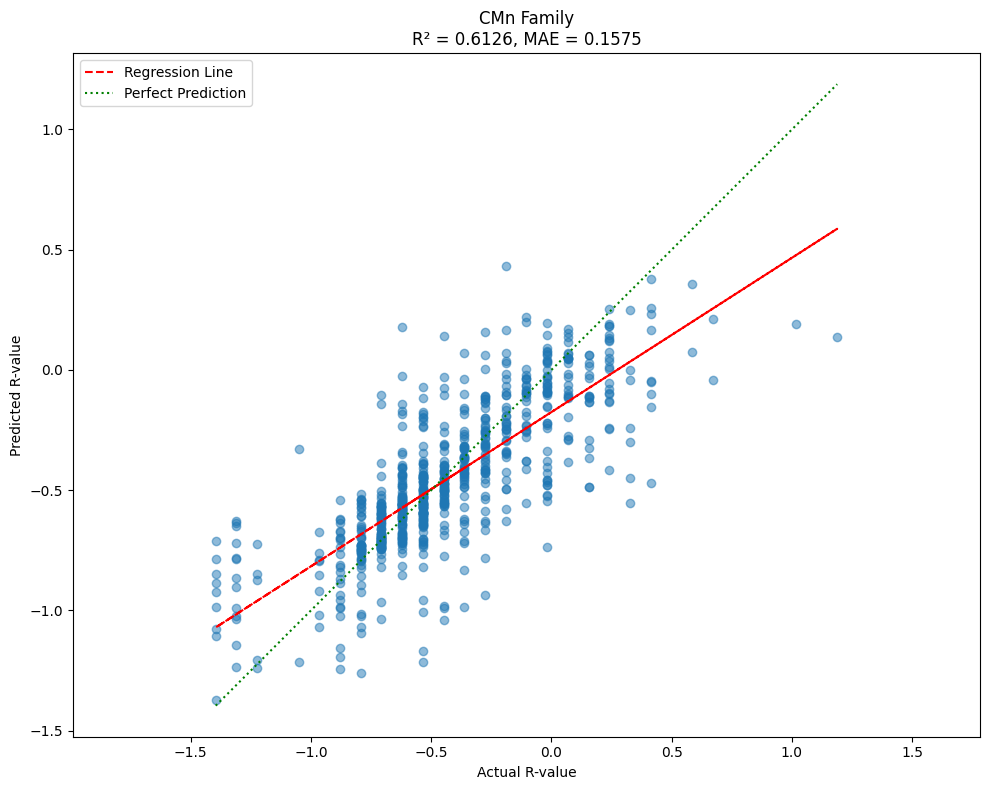

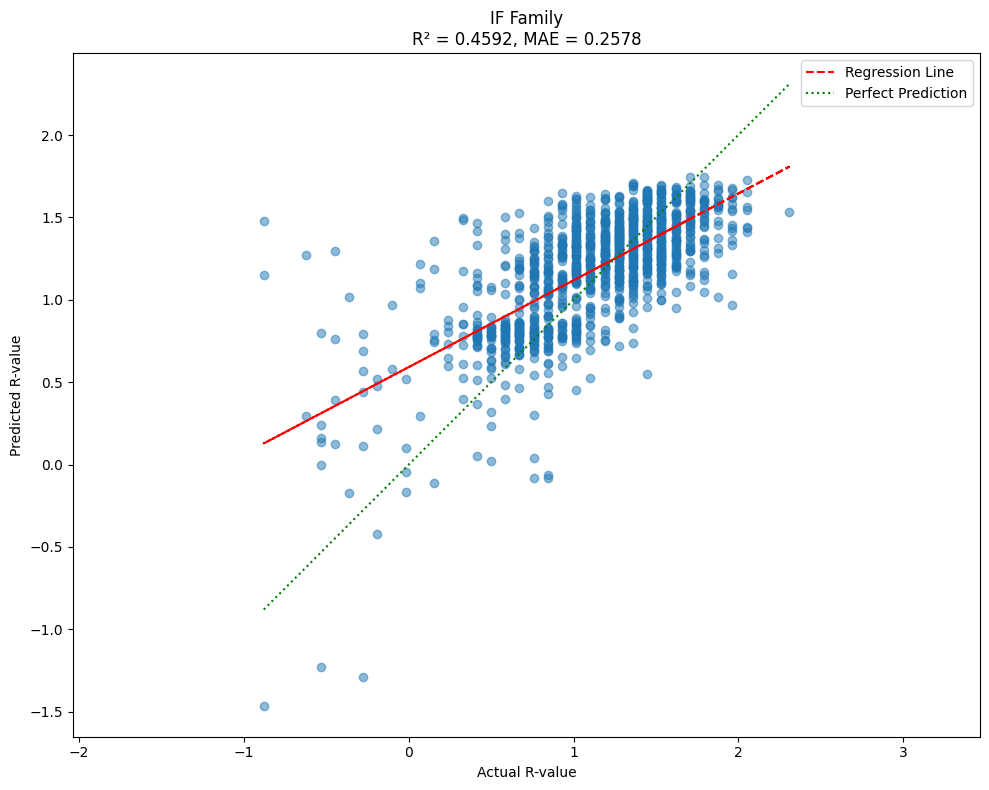

In [33]:
plot_actual_vs_predicted(test_scaled_df, family_models, features_dict)